# Generate $\tilde{C}^{\rm th}_{\ell}$ based on window function

In [1]:
#auto load changes 
%load_ext autoreload
%autoreload 2

#line profiler
%load_ext line_profiler

In [2]:
import numpy as np

import sys
sys.path.insert(1, '../src/')
import params as pm
from lib import cgll, read_img_map
from skylens import *
from astropy.cosmology import Planck15 as planck15

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [3]:
#setting up virtual dask cluster for calculations. Adjust memory and threads according to your system.
from distributed import LocalCluster
from dask.distributed import Client 
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
c=LocalCluster(n_workers=4,processes=True,memory_limit='150gb',threads_per_worker=1,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms')
client=Client(c)

In [4]:
#Import wigner files
wigner_files={}
wigner_files[0]= '/home/tkarim/SkyLens/temp/dask_wig3j_l2048_w4096_0_reorder.zarr/'

In [5]:
#define correlation pairs
#corr_kk=('kappa', 'kappa')
corr_gg=('galaxy','galaxy')
#corr_kg=('kappa', 'galaxy')

corrs = [corr_gg]
#spin factors for different correlations.
s1_s2s={}
s1_s2s[corr_gg]=(0,0)
#s1_s2s[corr_kk]=(0,0)
#s1_s2s[corr_kg]=(0,0)

#plot labels for different correlations
corr_labels={corr:{} for corr in s1_s2s.keys()}
corr_labels[corr_gg][(0,0)]=r'$gg$'
#corr_labels[corr_kk][(0,0)]=r'$\kappa \kappa$'
#corr_labels[corr_kg][(0,0)]=r'$\kappa g$'

#arguments to append to filenames for different correlations
corr_fnames={corr:{} for corr in s1_s2s.keys()}
corr_fnames[corr_gg][(0,0)]='gg'
#corr_fnames[corr_kk][(0,0)]='kk'
#corr_fnames[corr_kg][(0,0)]='kg'

#do not compute non-gaussian covariance.
SSV_cov=False
tidal_SSV_cov=False
Tri_cov=False

sparse_cov=True

#USE CORRECT FSKY
f_sky= pm.fsky

nz_PS=100

store_win=True

bi=(0,0) #tracer bin indices for cross correlations. always zero because we only use 1 tomographic bin.

def corr_matrix(cov_mat=[]): #correlation matrix
    diag=np.diag(cov_mat)
    return cov_mat/np.sqrt(np.outer(diag,diag))

In [6]:
#setup Skylens args
do_cov=False # if you want to get covariance. Covariance is slow and this should be false if you are calling skylens inside mcmc.
bin_cl=True #bin the theory and covaraince. 

use_window=False #if you want to include the window effect. Code will return pseudo-cl and pseudo-cl covariance
store_win=True # to store window, for some internal reasons. leave it to true.


use_binned_l=False  #FIXME: to speed up computation if using pseudo-cl inside mcmc. Needs to be tested. Leave it false for now.

SSV_cov=False # we donot have good model for super sample and tri-spectrum. We can chat about implementing some approximate analytical forms.
tidal_SSV_cov=False
Tri_cov=False 

bin_xi=True

#setup Skylens parameters

test = False

if test:
    NSIDE = 256
    lmax_cl = 3 * NSIDE
    binsize = 10
else:
    NSIDE = pm.NSIDE
    lmax_cl = 2 * NSIDE
    binsize = 100

lmin_cl=0
l0=np.arange(lmin_cl,lmax_cl)

#following defines the ell bins. Using log bins in example, feel free to change.
lmin_cl_Bins=100
lmax_cl_Bins=lmax_cl-10
Nl_bins=20
#l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
l_bins = np.arange(lmin_cl, lmax_cl, binsize)
#lb=np.sqrt(l_bins[1:]*l_bins[:-1])
lb=0.5*(l_bins[1:]+l_bins[:-1])

l=l0
# l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if computation is too heavy and we want to use fewer ell
window_lmax=2*lmax_cl #smaller value for testing. This should be 2X ell_max in the measurements.

In [7]:
#define cosmology parameters
cosmo_params=dict({'h':planck15.h,
                   'Omb':planck15.Ob0,
                   'Omd':planck15.Om0-planck15.Ob0,
                   'Om':planck15.Om0,
                   's8':0.817,
                   'Ase9':2.2,
                   'mnu':planck15.m_nu[-1].value,
                   'Omk':planck15.Ok0,
                   'tau':0.06,
                   'ns':0.965,
                   'OmR':planck15.Ogamma0+planck15.Onu0,
                   'w':-1,
                   'wa':0,
                   'T_cmb':planck15.Tcmb0,
                   'Neff':planck15.Neff,
                   'z_max':2.45,
                   'use_astropy':True})

In [8]:
def set_window_here(ztomo_bins_dict={}, nside=1024, mask = None, unit_win=False, cmb=False):
    """
        This function sets the window functions for the datasets. 
        These windows are necessary for converting cl to pseudo-cl.
    """
    #FIXME: make sure nside, etc. are properly matched. if possible, use same nside for cmb and galaxy maps. Use ud_grade where necessary.
    for i in np.arange(ztomo_bins_dict['n_bins']):
        if unit_win:
            cl_map=hp.ma(np.ones(12*nside*nside))
            cl_i=1
        elif cmb:
            #cl_map=np.load('/mnt/store1/tkarim/mask_2048.fits') #FIXME: add the CMB lensing window here.
            #window_map=np.load("/mnt/store1/boryanah/AbacusSummit_base_c000_ph006/light_cones/mask_edges_ring_2048.npy")
            #window_map=np.load("/home/tkarim/imaging-sys-covariance/dat/windows/Favg/Favg_map_unpickled.npy")
            #window_map = window_map.astype(np.float64)
            #window_map_noise = window_map
            #mask = cl_map
            print("cmb")
        else:
            window_map=np.load("/home/tkarim/imaging-sys-covariance/dat/windows/Favg/Favg_map_unpickled.npy") #randoms are the window function.
            #window_map=np.load("/mnt/store1/boryanah/AbacusSummit_base_c000_ph006/light_cones/mask_edges_ring_2048.npy") #randoms are the window function.
            window_map = window_map.astype(np.float64)
            window_map_noise = np.sqrt(window_map)
        
        if mask is None:
            mask=window_map>0 #FIXME: input proper mask if possible
        window_map[window_map<0]=0 #numerical issues can make this happen
        window_map/=window_map[mask].mean() #normalize window to 1
        window_map[~mask]=hp.UNSEEN
        window_map_noise[~mask]=hp.UNSEEN
        
        ztomo_bins_dict[i]['window']=window_map
        ztomo_bins_dict[i]['window_N']=window_map_noise #window of noise 

    return ztomo_bins_dict

def zbin_pz_norm(ztomo_bins_dict={},tomo_bin_indx=None,zbin_centre=None,p_zspec=None,ns=0,bg1=1,
                 mag_fact=0,k_max=0.3):
    """
        This function does few pre-calculations and sets some parameters for datasets that 
        will be input into skylens.
    """

    dzspec=np.gradient(zbin_centre) if len(zbin_centre)>1 else 1 #spec bin width

    if np.sum(p_zspec*dzspec)!=0:
        p_zspec=p_zspec/np.sum(p_zspec*dzspec) #normalize histogram
    else:
        p_zspec*=0
    nz=dzspec*p_zspec*ns

    i=tomo_bin_indx
    x= p_zspec>-1 #1.e-10; incase we have absurd p(z) values

    ztomo_bins_dict[i]['z']=zbin_centre[x]
    ztomo_bins_dict[i]['dz']=np.gradient(zbin_centre[x]) if len(zbin_centre[x])>1 else 1
    ztomo_bins_dict[i]['nz']=nz[x]
    ztomo_bins_dict[i]['ns']=ns
    ztomo_bins_dict[i]['W']=1. #redshift dependent weight
    ztomo_bins_dict[i]['pz']=p_zspec[x]*ztomo_bins_dict[i]['W']
    ztomo_bins_dict[i]['pzdz']=ztomo_bins_dict[i]['pz']*ztomo_bins_dict[i]['dz']
    ztomo_bins_dict[i]['Norm']=np.sum(ztomo_bins_dict[i]['pzdz'])
    ztomo_bins_dict[i]['b1']=bg1 # FIXME: this is the linear galaxy bias. Input proper values. We can also talk about adding other bias models if needed.
    ztomo_bins_dict[i]['bz1'] = None #array; set b1 to None if passing redz dependent bias 
    ztomo_bins_dict[i]['AI']=0. # this will be zero for our project
    ztomo_bins_dict[i]['AI_z']=0. # this will be zero for our project
    ztomo_bins_dict[i]['mag_fact']=mag_fact  #FIXME: You need to figure out the magnification bias prefactor. For example, see appendix B of https://arxiv.org/pdf/1803.08915.pdf
    ztomo_bins_dict[i]['shear_m_bias'] = 1.  #
    
    #convert k to ell
    zm=np.sum(ztomo_bins_dict[i]['z']*ztomo_bins_dict[i]['pzdz'])/ztomo_bins_dict[i]['Norm']
    ztomo_bins_dict[i]['lm']=k_max*cosmo_h.comoving_transverse_distance(zm).value 
    return ztomo_bins_dict

def source_tomo_bins(zphoto_bin_centre=None,p_zphoto=None,ntomo_bins=None,ns=26,
                     zspec_bin_centre=None,n_zspec=100,ztomo_bins=None,
                     f_sky=0.3,nside=256,use_window=False,
                    bg1=1,l=None,mag_fact=0,
                    k_max=0.3,use_shot_noise=True,**kwargs):
    """
        Setting galaxy redshift bins in the format used in skylens code.
        Need
        zbin_centre (array): redshift bins for every source bin. if z_bins is none, then dictionary with
                    with values for each bin
        p_zs: redshift distribution. same format as zbin_centre
        z_bins: if zbin_centre and p_zs are for whole survey, then bins to divide the sample. If
                tomography is based on lens redshift, then this arrays contains those redshifts.
        n_gal: number density for shot noise calculation
        n_zspec : number of histogram bins in spectroscopic dndz (if zspec_bin_centre is not passed)
        ztomo_bins : edges of tomographic bins in photometric redshift (assign galaxies to tomo bins using photz)
                    e.g. [0.6, 1., 1.6]
        k_max : cut in k-space; CHECK FOR BUG
    """
    ztomo_bins_dict={} #dictionary of tomographic bins

    if ntomo_bins is None:
        ntomo_bins=1

    if ztomo_bins is None:
        ztomo_bins=np.linspace(min(zphoto_bin_centre)-0.0001,max(zphoto_bin_centre)+0.0001,ntomo_bins+1)
    if zspec_bin_centre is None: #histogram of dndz; defines bin centres
        zspec_bin_centre=np.linspace(0,max(ztomo_bins)+1,n_zspec)
    dzspec=np.gradient(zspec_bin_centre)
    dzphoto=np.gradient(zphoto_bin_centre) if len(zphoto_bin_centre)>1 else [1]
    zphoto_bin_centre=np.array(zphoto_bin_centre)

    #zl_kernel=np.linspace(0,max(zbin_centre),50) #galaxy position kernel; identical to b*dndz
    #lu=Tracer_utils() 
    #cosmo_h=cosmo_h_PL #cosmology parameters in astropy convention; default is Skylens default

    zmax=max(ztomo_bins)

    l=[1] if l is None else l
    ztomo_bins_dict['SN']={} #shot noise dict
    ztomo_bins_dict['SN']['galaxy']=np.zeros((len(l),ntomo_bins,ntomo_bins)) # ell X no. of tomo bins X no. of tomo bins 
    ztomo_bins_dict['SN']['kappa']=np.zeros((len(l),ntomo_bins,ntomo_bins))

    for i in np.arange(ntomo_bins):
        ztomo_bins_dict[i]={}
        indx=zphoto_bin_centre.searchsorted(ztomo_bins[i:i+2]) #find bins that belong to this photometric bin

        if indx[0]==indx[1]: #if only one bin
            indx[1]=-1
        zbin_centre=zphoto_bin_centre[indx[0]:indx[1]]
        p_zspec=p_zphoto[indx[0]:indx[1]] #assuming spectroscopic and photometric dndz are same; CHANGE IF NOT 
        nz=ns*p_zspec*dzphoto[indx[0]:indx[1]]
        ns_i=nz.sum()

        ztomo_bins_dict = zbin_pz_norm(ztomo_bins_dict=ztomo_bins_dict, tomo_bin_indx=i, 
                                       zbin_centre=zbin_centre,
                                       p_zspec=p_zspec,ns=ns_i,bg1=bg1, mag_fact=mag_fact,k_max=k_max)
        
        zmax=max([zmax,max(ztomo_bins_dict[i]['z'])])
        if use_shot_noise:
            ztomo_bins_dict['SN']['galaxy'][:,i,i]=galaxy_shot_noise_calc(zg1=ztomo_bins_dict[i],
                                                                  zg2=ztomo_bins_dict[i])
            #the following is set in the CMB lensing bin
            #zs_bins['SN']['kappa'][:,i,i]=shear_shape_noise_calc(zs1=zs_bins[i],zs2=zs_bins[i],
            #                                                     sigma_gamma=sigma_gamma) #FIXME: This is almost certainly not correct

    ztomo_bins_dict['n_bins']=ntomo_bins #easy to remember the counts
    #ztomo_bins_dict['z_lens_kernel']=zl_kernel
    ztomo_bins_dict['zmax']=zmax
    ztomo_bins_dict['zp']=zphoto_bin_centre
    ztomo_bins_dict['pz']=p_zphoto
    ztomo_bins_dict['z_bins']=ztomo_bins
    
    if use_window:
        ztomo_bins_dict=set_window_here(ztomo_bins_dict=ztomo_bins_dict,nside=nside, unit_win=False)
    return ztomo_bins_dict

def DESI_elg_bins(ntomo_bins=1, f_sky=0.3,nside=256,use_window=True, bg1=1, 
                       l=None, mag_fact=0,ztomo_bins=None,**kwargs):

    home='/home/tkarim/'
    fname='nz_blanc+abacus.txt'
#     t=np.genfromtxt(home+fname,names=True,skip_header=3)
    #t=np.genfromtxt(home+fname,names=True)
    t = pd.read_csv(home + fname)
    dz=t['Redshift_mid'][2]-t['Redshift_mid'][1]
    zmax=max(t['Redshift_mid'])+dz/2
    zmin=min(t['Redshift_mid'])-dz/2

    z=t['Redshift_mid']
    
    pz=t['dndz/deg^2']
    
    ns=np.sum(pz)
    d2r = 180/np.pi
    ns/=d2r**2 #convert from deg**2 to rd**2

    if ztomo_bins is None: #this defines the bin edges if splitting the sample into bins. Preferably pass it as an argument whenusing multiple bins.
        ztomo_bins=np.linspace(zmin, min(2,zmax), ntomo_bins+1) #define based on experiment
    print(zmin,zmax,ztomo_bins,ns)
    return source_tomo_bins(zphoto_bin_centre=z, p_zphoto=pz, ns=ns, ntomo_bins = ntomo_bins,
                            mag_fact=mag_fact, ztomo_bins=ztomo_bins,f_sky=f_sky,nside=nside,
                            use_window=use_window,bg1=bg1, l=l,**kwargs)

In [9]:
def SkyLens_cls(nside, bg1, fsky, zmin = 0.1, zmax = 2.45104189964307, nowin = False, Win = None):
    """Returns Skylens Cls based on given maps.
    
    Inputs:
        nside (int) : nside for healpy
        bg1 (float) : linear bias term for galaxies
        fsky (float) : fsky of the map to be used 
        zmin (float) : min redshift for CMB lensing kernel
        zmax (float) : max redshift for CMB lensing kernel
        nowin (bool) : whether to calculate Cls without window
        Win (dict) : optional dict; pass saved window calculated before
        
    Returns:
        results (dict) : Skylens dict containing Cls, pCls, coupling matrices
    """
    
    results = {}
    
    #tomographed redshift bins for the galaxies
    #zl_bin=DESI_elg_bins(l=l, f_sky = fsky, nside = NSIDE, bg1 = bg1) #originally l = None
    zl_bin=DESI_elg_bins(l=l, f_sky = fsky, nside = NSIDE, bg1 = bg1)
    
    #names of maps
    #corrs=[corr_kk, corr_gg, corr_gk]
    corrs=[corr_gg]
    
    z_PS=np.linspace(zmin, zmax, 100) #redshifts where P(k) will be evaluated
    
    if Win is not None:
        kappa0=Skylens(do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, galaxy_zbins=zl_bin,
                                       use_window=use_window,Tri_cov=Tri_cov, Win = Win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=fsky,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                                       cosmo_params = cosmo_params, z_PS=z_PS)
        
    else:
        kappa0=Skylens(do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, galaxy_zbins=zl_bin,
                                       use_window=use_window,Tri_cov=Tri_cov, #Win = Win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=fsky,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                                        #z_PS=z_PS)
                       cosmo_params = cosmo_params, z_PS=z_PS)
    results['kappa0'] = kappa0
    
    if(nowin):
        kappa0_nowin=Skylens(do_cov=False,bin_cl=False,l_bins=None,l=l0_nowin, 
                     galaxy_zbins=zl_bin,
                                       use_window=False,Tri_cov=Tri_cov, #Win = Win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=fsky,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                                        #z_PS=z_PS)
                             cosmo_params = cosmo_params, z_PS=z_PS)
        results['kappa0_nowin'] = kappa0_nowin
    
    return results

### Run Skylens via dask

In [10]:
client

Client Scheduler: tcp://127.0.0.1:42403 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 600.00 GB


In [11]:
zlow = 0.1
zhigh = 2.45104189964307

%time results = SkyLens_cls(nside = pm.NSIDE, bg1 = pm.b1, \
                            fsky = pm.fsky, \
                            zmin = zlow, zmax = zhigh, \
                            nowin = False)

0.41250000000000003 1.4374999999999996 [0.4125 1.4375] 4.570437260729055
Tracer utils has tracers:  ['galaxy']
pk_params dict was none, intialized with default
{'h': 0.6774, 'Omb': 0.0486, 'Omd': 0.2589, 'Om': 0.3075, 's8': 0.817, 'Ase9': 2.2, 'mnu': 0.06, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.965, 'OmR': 0.0014901684738813567, 'w': -1, 'wa': 0, 'T_cmb': <Quantity 2.7255 K>, 'Neff': 3.046, 'z_max': 2.45, 'use_astropy': True}
power spectra class_pk
Win gen: step size 4 2048 4097.0 4
Window done. Size: 0.0
CPU times: user 6.26 s, sys: 888 ms, total: 7.15 s
Wall time: 6.7 s


/home/tkarim/anaconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/cov_utils.py:92: RuntimeWarning: invalid value encountered in true_divide
/home/tkarim/anaconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide


In [12]:
%time cl0G=results['kappa0'].cl_tomo() 

scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
CPU times: user 21.9 s, sys: 1.21 s, total: 23.1 s
Wall time: 20.7 s


In [13]:
#read in wigner-3j matrices.
l_cl=results['kappa0'].l
window_l=results['kappa0'].window_l
wu=window_utils(l=l_cl,window_l=window_l,use_window=True,s1_s2s={corr_gg:s1_s2s[corr_gg]},
                corrs=corrs,wigner_step=100,wigner_files=wigner_files)
wu.set_wig3j()

Win gen: step size 100 2048 4097.0 10
wigner_files: {0: '/home/tkarim/SkyLens/temp/dask_wig3j_l2048_w4096_0_reorder.zarr/'}
wigner done dict_keys([])


In [14]:
Cl0=client.compute(cl0G['cl'][corr_gg][bi]).result() #we use same C_ell correlation as window C_l to compute M^W

Save $C_{\ell}^{\rm th}$ to pass to `src/pCl.py` to generate mocks

In [15]:
np.save('../dat/cosmology_ini/gaussian_mocks/cl_th.npy', Cl0, allow_pickle=False)

In [16]:
#BETTER TO CORRECT p-CL WITH NOISE RATHER CALCULATING COUPLING MATRIX OF NOISE
#BECAUSE NOISE IS FLAT SO L, L' ASSUMPTION IS NO LONGER TRUE

#THIS IS C5 IN THE PAPER

M_lm={} #coupling submatrix 
#MN_lm={}

nl=len(wu.l) #number of l
nlw=len(wu.window_l)
nl_cl=len(wu.l)

M=np.zeros((nl,nlw)) #full coupling matrix
#M_N=np.zeros((nl,nlw))

for lm in wu.lms:
    wj2i=client.compute(wu.wig_3j_2[lm]).result()
    wj2i=wj2i['00']
    wj2i=wj2i.transpose(0,2,1)
    start_i=lm
    end_i=lm+wu.step
    M_lm[lm]=wj2i@(Cl0*(2*l0+1))
    M[start_i:end_i,:]+=M_lm[lm]
    del M_lm[lm]
    #MN_lm[lm]=wj2i@(np.ones_like(win_Cl)*(2*l0+1))
    #M_N[start_i:end_i,:]+=MN_lm[lm]

    print(lm,'done')
M/=4.*np.pi
M*=(2*wu.window_l+1)
#M_N/=4.*np.pi
#M_N*=(2*wu.window_l+1)

0 done
100 done
200 done
300 done
400 done
500 done
600 done
700 done
800 done
900 done
1000 done
1100 done
1200 done
1300 done
1400 done
1500 done
1600 done
1700 done
1800 done
1900 done
2000 done


In a loop, we read in Window functions, $W_i$, calculate the power spectrum of the windows, $C^{W_{i}}_{\ell}$, and then convolve with the coupling matrix, $M$ to get the expected power spectrum (theoretical), i.e.

\begin{equation}
\tilde{C}^{\rm th_{i}}_{\ell}  = M {C}^{W_{i}}_{\ell}
\end{equation}

In [17]:
import sys

#list of all selection function fits files
import glob
window_list = glob.glob("../dat/windows/*fits")

In [23]:
pcl_th = np.zeros((len(window_list), lmax_cl))

i = 0
window_cl_array = np.zeros((pm.NMOCKS, window_lmax))
for window in window_list:
    window_map = read_img_map(window)
    window_cl_array[i] = hp.anafast(window_map, lmax=window_lmax - 1, pol = False)
    #pcl_th[i] = M @ window_cl
   
    if((i % (100)) == 0):
        print(i)
    i += 1

0
100
200
300
400
500
600
700
800
900


Compare Window and Mask power spectra

In [56]:
#read in random to generate mask
dr_elg_ran = np.load("../dat/elg_ran1024.npy")
mask = np.copy(dr_elg_ran)
mask[dr_elg_ran != 0] = 1 #good pixels are 1
mask = mask.astype("bool")

In [57]:
mask_cl = hp.anafast(mask, lmax = window_lmax - 1, pol = False)

07:21:08 DEBUG:vmin 0.7071413255983454 vmax 1446.6697998938064
07:21:08 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
07:21:08 DEBUG:vmin 0.7071413255983454 vmax 1446.6697998938064
07:21:08 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
07:21:08 DEBUG:vmin 0.7071413255983454 vmax 1446.6697998938064
07:21:08 DEBUG:ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
07:21:09 DEBUG:vmin 0.7071

07:21:09 DEBUG:vmin 1.2605648744876542e-09 vmax 5.060413204792175
07:21:09 DEBUG:ticklocs array([1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03])
07:21:09 DEBUG:vmin 1.2605648744876542e-09 vmax 5.060413204792175
07:21:09 DEBUG:ticklocs array([], dtype=float64)
07:21:09 DEBUG:vmin 0.7071413255983454 vmax 1446.6697998938064
07:21:09 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
07:21:09 DEBUG:vmin 0.7071413255983454 vmax 1446.6697998938064
07:21:09 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
07:21:09 DEBUG:vmin 0.7071413255983454 vmax 1446.6697998938064
07:21:09 DEBUG:ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e

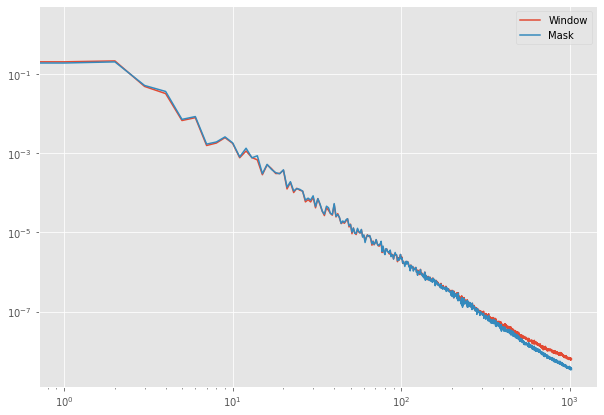

In [58]:
plt.figure(figsize=pm.fsize)
plt.loglog(pm.ell, window_cl_array.mean(axis = 0)[:pm.ell.shape[0]], label = 'Window')
plt.loglog(pm.ell, mask_cl[:pm.ell.shape[0]], label = 'Mask')
plt.legend(loc = 'best')

Text(0, 0.5, 'Window/Mask')

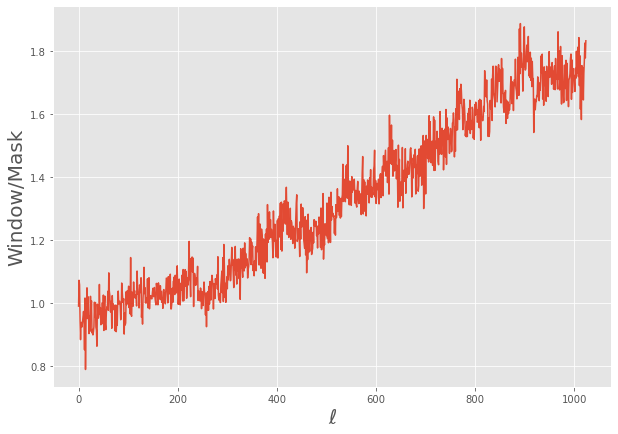

In [60]:
plt.figure(figsize=pm.fsize)
plt.plot(pm.ell, window_cl_array.mean(axis = 0)[:pm.ell.shape[0]]/mask_cl[:pm.ell.shape[0]])
plt.xlabel(r"$\ell$", fontsize = pm.fs)
plt.ylabel("Window/Mask", fontsize = pm.fs)

Save pCl and window list 

In [19]:
M.shape

(2048, 4097)

In [25]:
#np.save("../dat/pcl_th.npy", pcl_th, allow_pickle=False)
#np.save("../dat/pCls/th/couplingmatrix_BC.npy", M, allow_pickle=False)
np.save("../dat/windows/window_cls.npy", window_cl_array, allow_pickle=False)

In [24]:
window_cl_array.shape

(1000, 4096)

In [28]:
cov_window = np.cov(window_cl_array.T)

In [50]:
cov_window.shape

(4096, 4096)

In [30]:
Dinv = np.diag(1 / np.sqrt(np.diag(cov_window))) 
corr = Dinv @ cov_window @ Dinv

04:48:13 DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f3748fe8430>
04:48:13 DEBUG:Using auto colorbar locator on colorbar
04:48:13 DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f3748fe8430>
04:48:13 DEBUG:Setting pcolormesh
04:48:13 DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
04:48:13 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
04:48:13 DEBUG:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
04:48:13 DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
04:48:13 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
04:48:13 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
04:48:13 DEBUG:findfont: score(<Font 'DejaV

04:48:13 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Bold.ttf) normal normal 700 condensed>) = 10.535
04:48:13 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-BoldItalic.ttf) italic normal 700 condensed>) = 11.535
04:48:13 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed.ttf) normal normal 400 condensed>) = 0.25
04:48:13 DEBUG:findfont: score(<Font 'Lato' (Lato-HeavyItalic.ttf) italic normal heavy normal>) = 11.43
04:48:13 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 0.24
04:48:13 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
04:48:13 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 0.5349999999999999
04:48:13 DEBUG:findfont: score(<Font 'Lato' (Lato-Regular.ttf) normal normal regular normal>) = 10.05
04:48:13 DEBUG:findfont: Matching sans\-serif:style=normal:variant=n

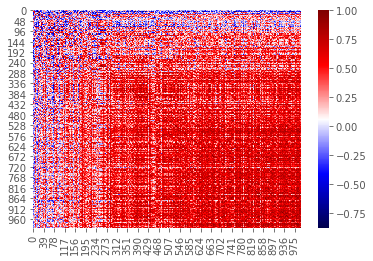

In [31]:
import seaborn as sns
sns.heatmap(corr[:1000, :1000], cmap = 'seismic')

In [40]:
cov_DD = M[:,:-1] @ cov_window @ M[:,:-1].T

In [41]:
cov_DD

array([[ 2.50462697e-19,  2.43411546e-19,  2.00729404e-19, ...,
        -4.17507510e-21, -3.59513831e-21, -8.03457984e-22],
       [ 2.43411546e-19,  2.36779202e-19,  1.96257582e-19, ...,
        -3.86352718e-21, -3.33773038e-21, -6.82696794e-22],
       [ 2.00729404e-19,  1.96257582e-19,  1.72229096e-19, ...,
        -2.02536946e-21, -1.54392985e-21, -3.72110837e-23],
       ...,
       [-4.17507510e-21, -3.86352718e-21, -2.02536946e-21, ...,
         2.58715565e-22,  2.27680200e-22,  1.06855996e-22],
       [-3.59513831e-21, -3.33773038e-21, -1.54392985e-21, ...,
         2.27680200e-22,  2.14977107e-22,  9.16159561e-23],
       [-8.03457984e-22, -6.82696794e-22, -3.72110837e-23, ...,
         1.06855996e-22,  9.16159561e-23,  5.01681546e-23]])

In [42]:
Dinv_DD = np.diag(1 / np.sqrt(np.diag(cov_DD))) 
corr_DD = Dinv_DD @ cov_DD @ Dinv_DD

07:23:30 DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f36b811ef10>
07:23:30 DEBUG:Using auto colorbar locator on colorbar
07:23:30 DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f36b811ef10>
07:23:30 DEBUG:Setting pcolormesh


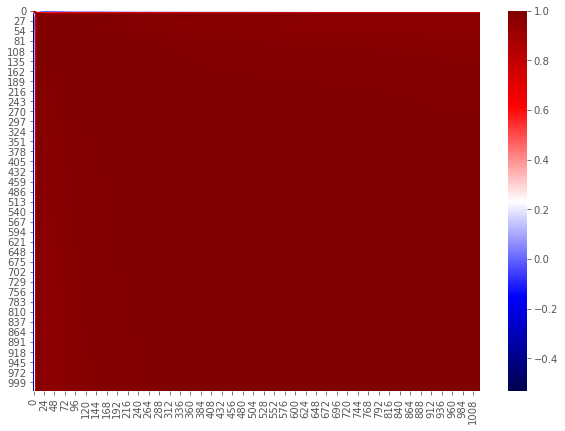

In [63]:
plt.figure(figsize=pm.fsize)
sns.heatmap(corr_DD[:1024, :1024], cmap = 'seismic')

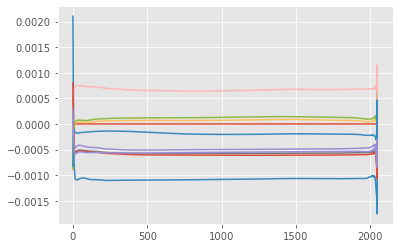

In [57]:
ell = np.arange(0, lmax_cl)
for i in range(10):
    plt.plot(ell, pcl_th[i]/pcl_th[0] - 1)
#lt.loglog(ell, Cl0)

In [59]:
window_map = np.load("../dat/windows/Favg/Favg_map_unpickled.npy")
window_cl = hp.anafast(window_map, lmax=window_lmax, pol = False)
pcl_th_Favg = M @ window_cl

In [60]:
np.save('../dat/pcl_th_Favg.npy', pcl_th_Favg, allow_pickle=False)

In [63]:
np.save('../dat/window_list_ordered.npy', window_list, allow_pickle=False)

In [64]:
pwd

'/home/tkarim/imaging-sys-covariance/notebooks'